In [4]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML

display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

dm1_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm2.fits')


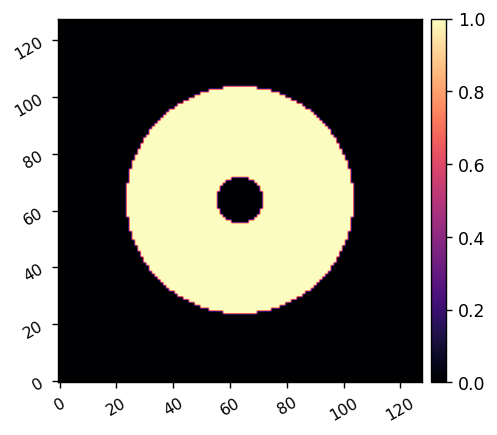

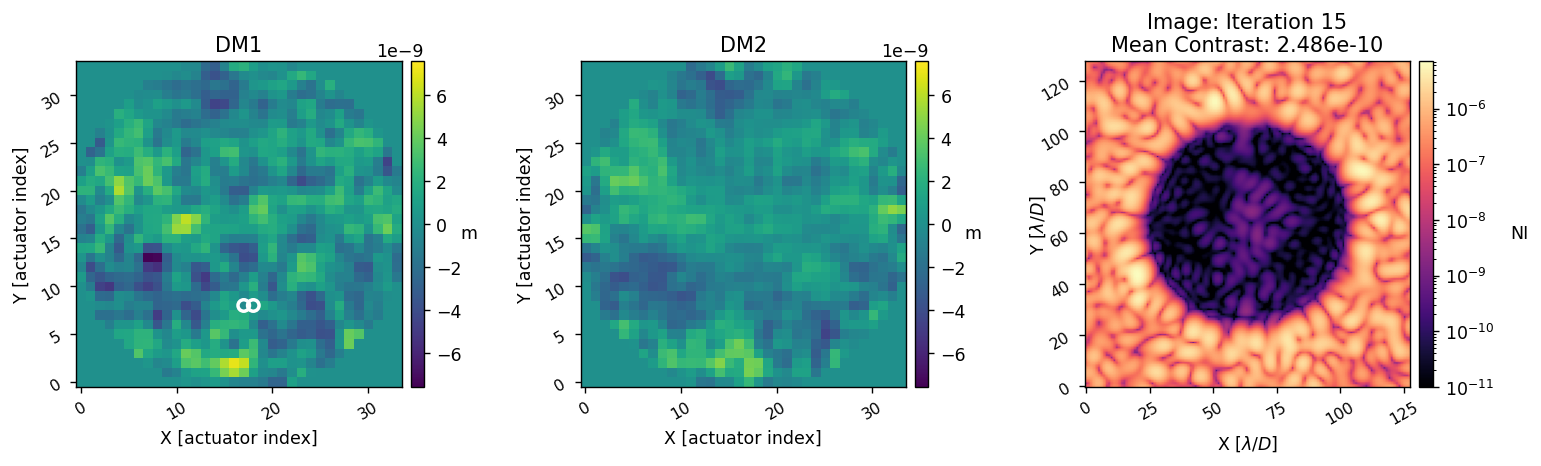

In [16]:
import hcipy_models as hcim
reload(hcim)
npix = 256
oversample = 2
svc = hcim.SVC(npix=npix, oversample=oversample)
control_mask = ensure_np_array(utils.create_annular_focal_plane_mask(svc, inner_radius=2, outer_radius=10, edge=None, plot=True))

Nact = 34

date = 20231216
svc_dm1s = fits.getdata(response_dir/f'hcipy_svc_dm1_commands_{date}.fits')
svc_dm2s = fits.getdata(response_dir/f'hcipy_svc_dm2_commands_{date}.fits')
svc_images = fits.getdata(response_dir/f'hcipy_svc_images_{date}.fits')

i = 15
contrast = xp.mean(svc_images[i][control_mask])
probe_inds_1 = np.array([Nact//2, Nact//4])
probe_inds_2 = np.array([Nact//2+1, Nact//4])

patches = [Circle((probe_inds_1[0],probe_inds_1[1]), 0.6, color='w', fill=False, linewidth=2),
           Circle((probe_inds_2[0],probe_inds_2[1]), 0.6, color='w', fill=False, linewidth=2)]

dm_max = np.max(np.abs(np.concatenate([svc_dm1s[i], svc_dm2s[i]])))
fig, ax = imshow3(svc_dm1s[i], svc_dm2s[i], svc_images[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {contrast:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='X [actuator index]', xlabel2='X [actuator index]', xlabel3='X [$\lambda/D$]', 
        # pxscl3=psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        patches1=patches,
        display_fig=False, return_fig=True)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
ax[0].set_ylabel('Y [actuator index]', labelpad=5)
ax[1].set_ylabel('Y [actuator index]', labelpad=5)
# fig.savefig('figs/hcipy_svc_dark_hole.pdf', format='pdf', bbox_inches="tight")
display(fig)


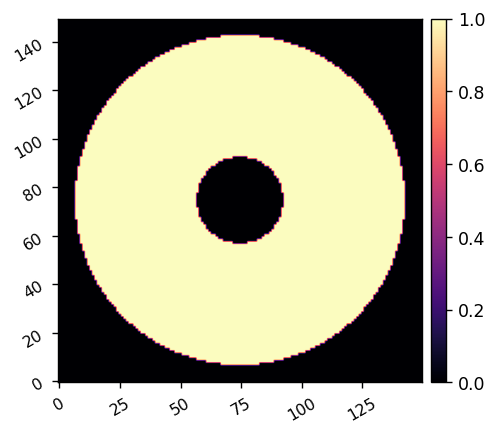

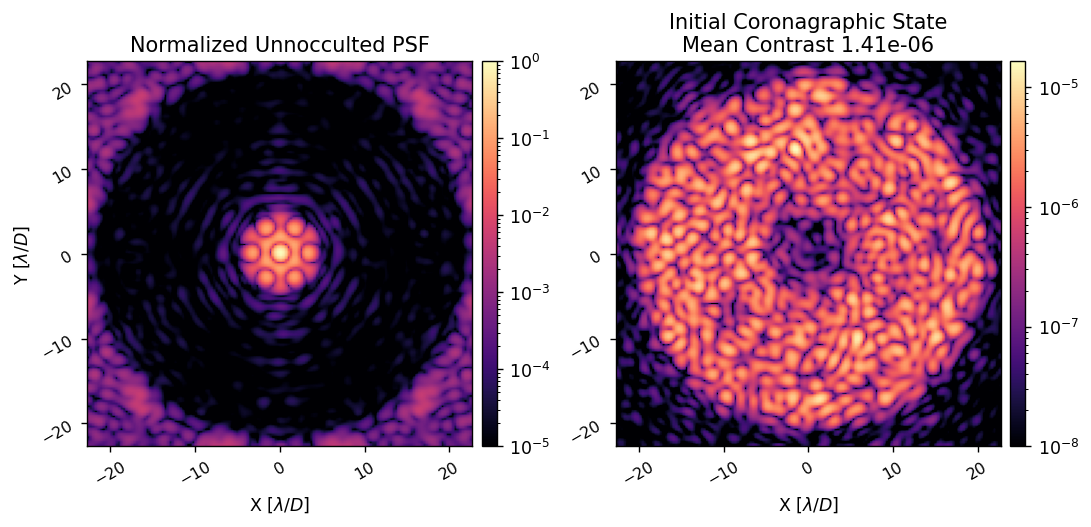

In [25]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                use_pupil_defocus=True, 
                                use_opds=True,
                                dm1_ref=dm1_flat, dm2_ref=dm2_flat,
                                )
mode.use_fpm = False
psf = mode.snap()

mode.Imax_ref = xp.max(psf)
ref_psf = mode.snap()
mode.use_fpm = True

ref_im = mode.snap()

reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)
mean_ni = xp.mean(ref_im[control_mask])

fig,ax = imshow2(ref_psf, ref_im, 'Normalized Unnocculted PSF', f'Initial Coronagraphic State\nMean Contrast {mean_ni:.2e}',
                pxscl=mode.psf_pixelscale_lamD, xlabel='X [$\lambda/D$]',
                lognorm=True, vmin1=1e-5, vmin2=1e-8, 
                return_fig=True, display_fig=False)
ax[0].set_ylabel('Y [$\lambda/D$]', )
# fig.savefig('figs/spc_wfov_initial_state.pdf', format='pdf', bbox_inches="tight")
display(fig)



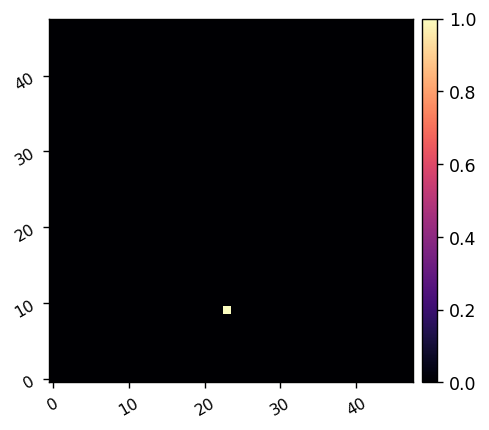

KeyboardInterrupt: 

In [4]:
command = np.zeros((mode.Nact,mode.Nact))
command[9,23] = 1
imshow1(command)

amps = np.linspace(0, 75, 76)*1e-9

rms_vals = np.zeros(len(amps))
for i,amp in enumerate(amps):
    mode.set_dm1(amp*command)
    e1 = mode.calc_psf()
    mode.set_dm1(-amp*command)
    e2 = mode.calc_psf()

    # response = (e1-e2)/(2*amp)
    response = (e1-e2)/(2)
    rms_vals[i] = xp.sqrt(xp.mean(xp.abs(response[control_mask])**2))

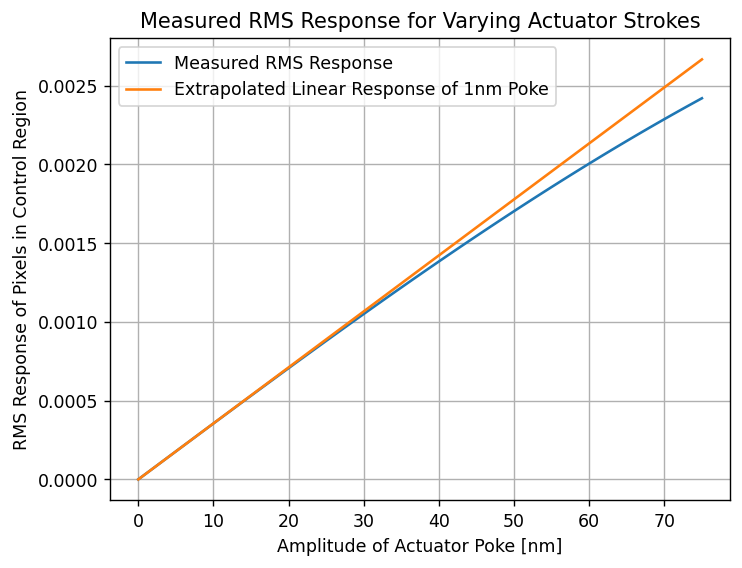

In [10]:
import matplotlib.pyplot as plt

slope = (rms_vals[1]-rms_vals[0])/(amps[1]-amps[0])

plt.figure(dpi=125)
plt.plot(amps*1e9, rms_vals, label='Measured RMS Response')
plt.plot(amps*1e9, slope*amps, label='Extrapolated Linear Response of 1nm Poke')
plt.grid()
plt.legend()
plt.title('Measured RMS Response for Varying Actuator Strokes')
plt.xlabel('Amplitude of Actuator Poke [nm]')
plt.ylabel('RMS Response of Pixels in Control Region')
plt.savefig('figs/nonlinear_response.pdf', format='pdf', bbox_inches="tight")

2.5513179788999333e-09


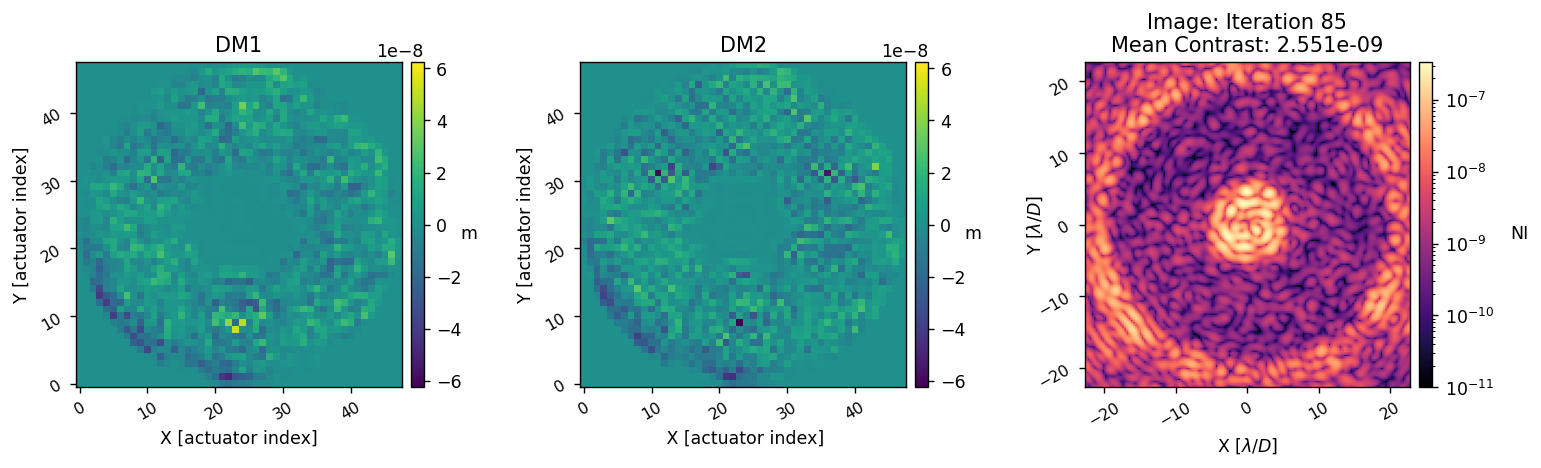

In [5]:
date = 20230921
date = 20231013
dm1s = fits.getdata(response_dir/f'spc_wfov_825_poke_modes_3pokes_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_825_poke_modes_3pokes_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_poke_modes_3pokes_images_{date}.fits')

poke_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)

i = np.argmin(poke_contrast)
print(poke_contrast[i])

dm_max = np.max(np.abs(np.concatenate([dm1s[i], dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9
fig, ax = imshow3(dm1s[i], dm2s[i], ims[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {poke_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='X [actuator index]', xlabel2=' X [actuator index]', xlabel3='X [$\lambda/D$]', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        display_fig=False, return_fig=True)
ax[0].set_ylabel('Y [actuator index]', labelpad=5)
ax[1].set_ylabel('Y [actuator index]', labelpad=5)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
fig.savefig('figs/spc_825_poke_modes_poke_probes.pdf', format='pdf', bbox_inches="tight")
display(fig)
# utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)

2.956956233174829e-08


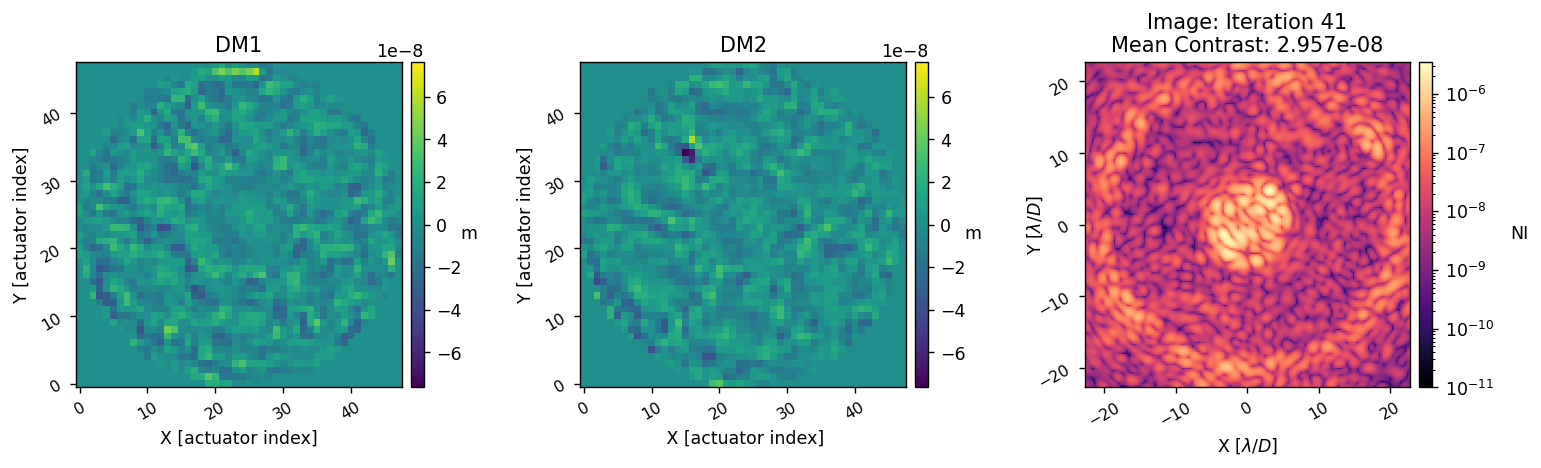

In [9]:
date = 20230926
date = 20231013
dm1s = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_0.85_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_0.85_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_0.85_images_{date}.fits')

fourier_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)
fourier_contrast.shape

i = np.argmin(fourier_contrast)
print(fourier_contrast[i])

dm_max = np.max(np.abs(np.concatenate([dm1s[i], dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9
fig, ax = imshow3(dm1s[i], dm2s[i], ims[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {fourier_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='X [actuator index]', xlabel2=' X [actuator index]', xlabel3='X [$\lambda/D$]', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        display_fig=False, return_fig=True)
ax[0].set_ylabel('Y [actuator index]', labelpad=5)
ax[1].set_ylabel('Y [actuator index]', labelpad=5)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
fig.savefig('figs/spc_825_fourier_modes_poke_probes.pdf', format='pdf', bbox_inches="tight")
display(fig)
# utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)

2.141313223564066e-09


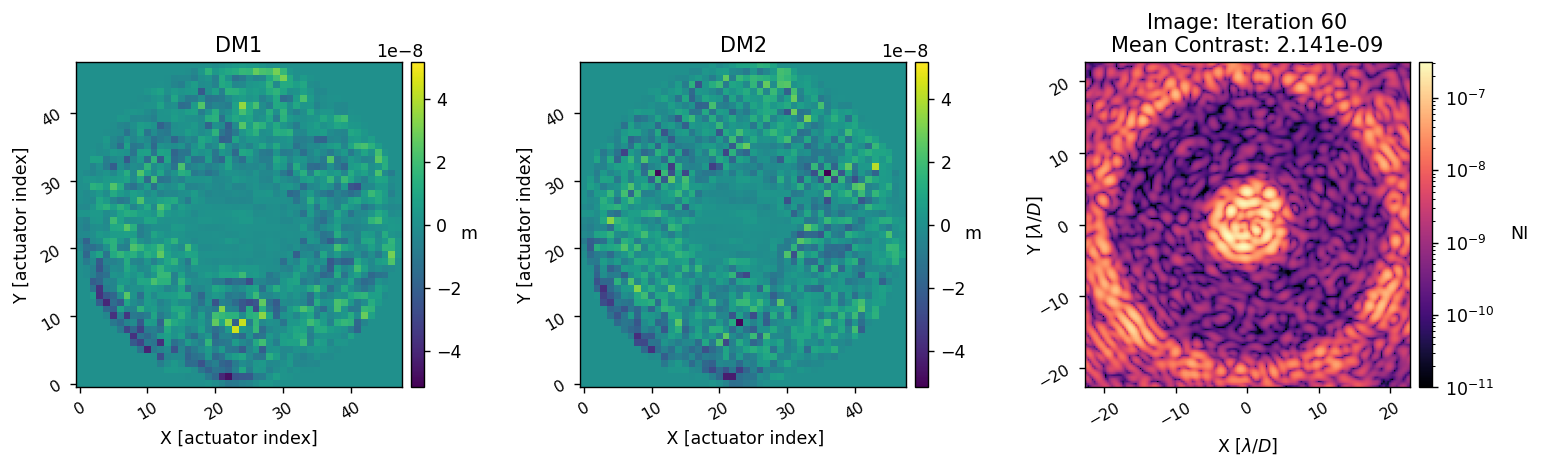

In [10]:
date = 20230925
date = 20231013
dm1s = fits.getdata(response_dir/f'spc_wfov_825_had_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_825_had_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_had_images_{date}.fits')

had_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)

i = np.argmin(had_contrast)
print(had_contrast[i])

dm_max = np.max(np.abs(np.concatenate([dm1s[i], dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9
fig, ax = imshow3(dm1s[i], dm2s[i], ims[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {had_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='X [actuator index]', xlabel2=' X [actuator index]', xlabel3='X [$\lambda/D$]', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        display_fig=False, return_fig=True)
ax[0].set_ylabel('Y [actuator index]', labelpad=5)
ax[1].set_ylabel('Y [actuator index]', labelpad=5)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
fig.savefig('figs/spc_825_had_modes_poke_probes.pdf', format='pdf', bbox_inches="tight")
display(fig)
# utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)


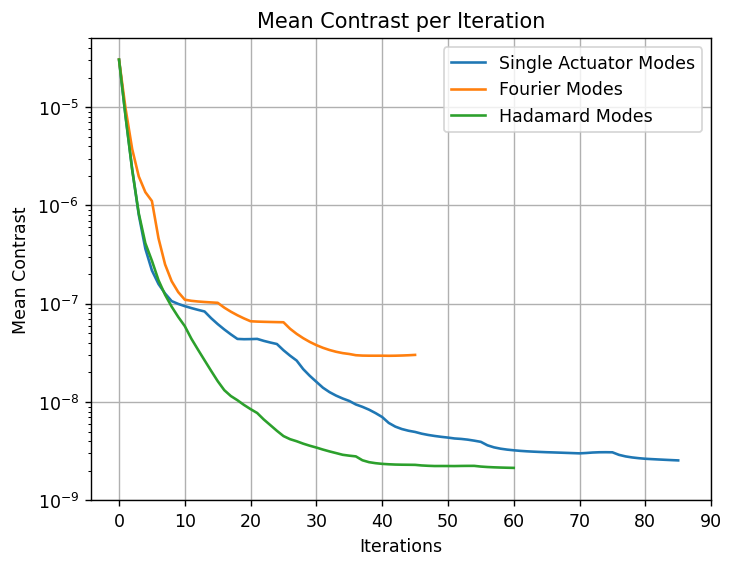

In [11]:
import matplotlib.pyplot as plt

plt.figure(dpi=125)

itrs = range(poke_contrast.shape[0])
plt.semilogy(itrs, poke_contrast, label='Single Actuator Modes')

itrs = range(fourier_contrast.shape[0])
plt.semilogy(itrs, fourier_contrast, label='Fourier Modes')


itrs = range(had_contrast.shape[0])
plt.semilogy(itrs, had_contrast, label='Hadamard Modes')
plt.xlabel('Iterations')
plt.ylabel('Mean Contrast')
plt.ylim([1e-9, 5e-5])
plt.xticks(np.arange(0,100, 10))
plt.legend()
plt.title('Mean Contrast per Iteration')
plt.grid()
plt.savefig('figs/contrast_per_iteration.pdf', format='pdf', bbox_inches="tight")


4.1533993438870624e-09


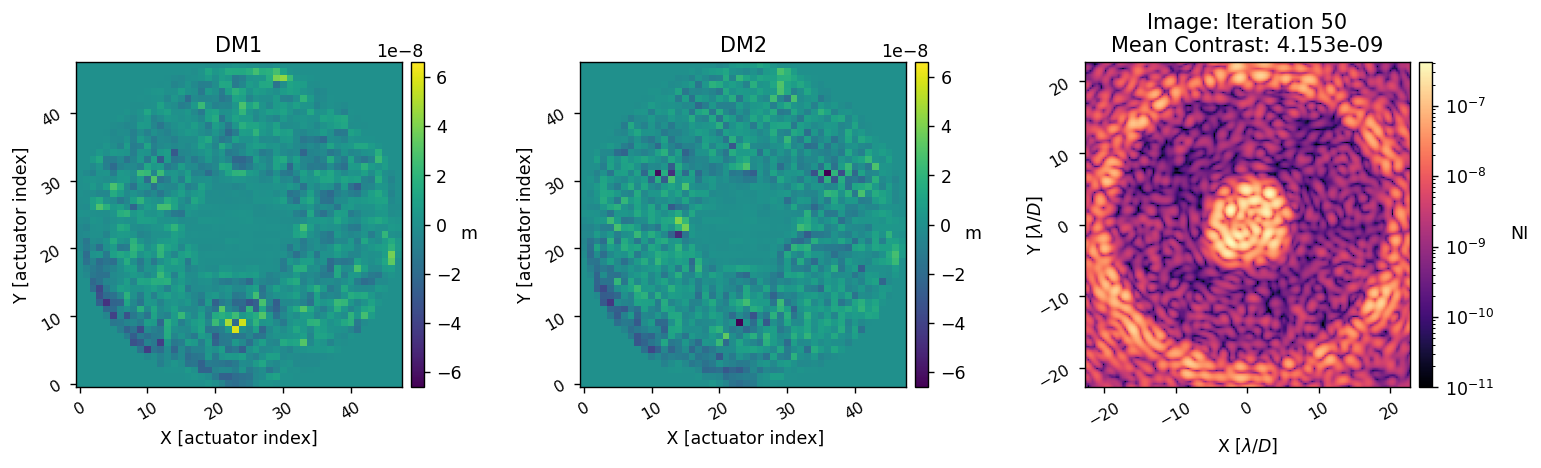

In [7]:
date = 20230925
date = 20231016
dm1s = fits.getdata(response_dir/f'spc_wfov_825_perturbed_had_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_825_perturbed_had_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_perturbed_had_images_{date}.fits')

perturbed_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)

i = np.argmin(perturbed_contrast)
print(perturbed_contrast[i])

dm_max = np.max(np.abs(np.concatenate([dm1s[i], dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9
fig, ax = imshow3(dm1s[i], dm2s[i], ims[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {perturbed_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='X [actuator index]', xlabel2=' X [actuator index]', xlabel3='X [$\lambda/D$]', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        display_fig=False, return_fig=True)
ax[0].set_ylabel('Y [actuator index]', labelpad=5)
ax[1].set_ylabel('Y [actuator index]', labelpad=5)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
fig.savefig('figs/iefc_perturbed_best_image.pdf', format='pdf', bbox_inches="tight")
display(fig)

# Plot Example modes

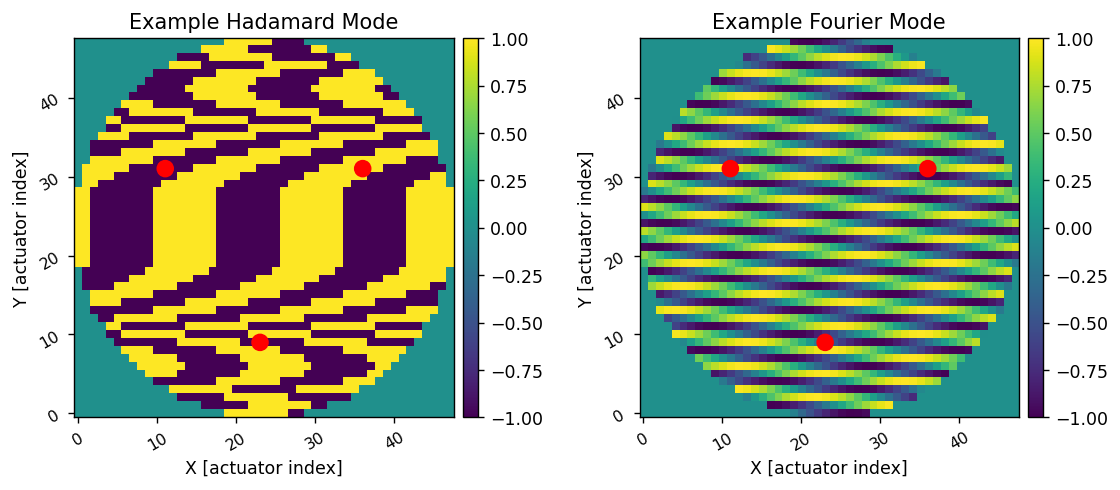

In [13]:
probe_amp = 2.5e-8
# probe_modes = utils.create_poke_probes([(10,34), (38,34), (24,10)], plot=True)
probe_modes = utils.create_poke_probes([(11,31), (36,31), (23,9)], plot=False)

had_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=1)
hi = 8
fourier_modes = utils.create_fourier_modes(mode, control_mask, fourier_sampling=1, ndms=1)
fi = 100

probe_1_ind = tuple(np.roll(np.argwhere(probe_modes[0])[0],1))
probe_2_ind = tuple(np.roll(np.argwhere(probe_modes[1])[0],1))
probe_3_ind = tuple(np.roll(np.argwhere(probe_modes[2])[0],1))
patches1 = [Circle(probe_1_ind, 1, color='red'), Circle(probe_2_ind, 1, color='red'), Circle(probe_3_ind, 1, color='red')]
patches2 = [Circle(probe_1_ind, 1, color='red'), Circle(probe_2_ind, 1, color='red'), Circle(probe_3_ind, 1, color='red')]

fig,ax = imshow2(had_modes[hi].reshape(mode.Nact,mode.Nact), fourier_modes[fi].reshape(mode.Nact,mode.Nact),
        'Example Hadamard Mode', 'Example Fourier Mode',
        xlabel='X [actuator index]',
        cmap1='viridis', cmap2='viridis', 
        patches1=patches1, 
        patches2=patches2,
        wspace=0.4,
        return_fig=True, display_fig=False,
        )
ax[0].set_ylabel('Y [actuator index]')
ax[1].set_ylabel('Y [actuator index]')
fig.savefig('figs/example_modes.pdf', format='pdf', bbox_inches="tight")
display(fig)

# Plot the RMS actuator responses


In [14]:
date = 20231013
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_825_poke_modes_response_matrix_{date}.fits'))

(3608, 4608)
2794403703.275511


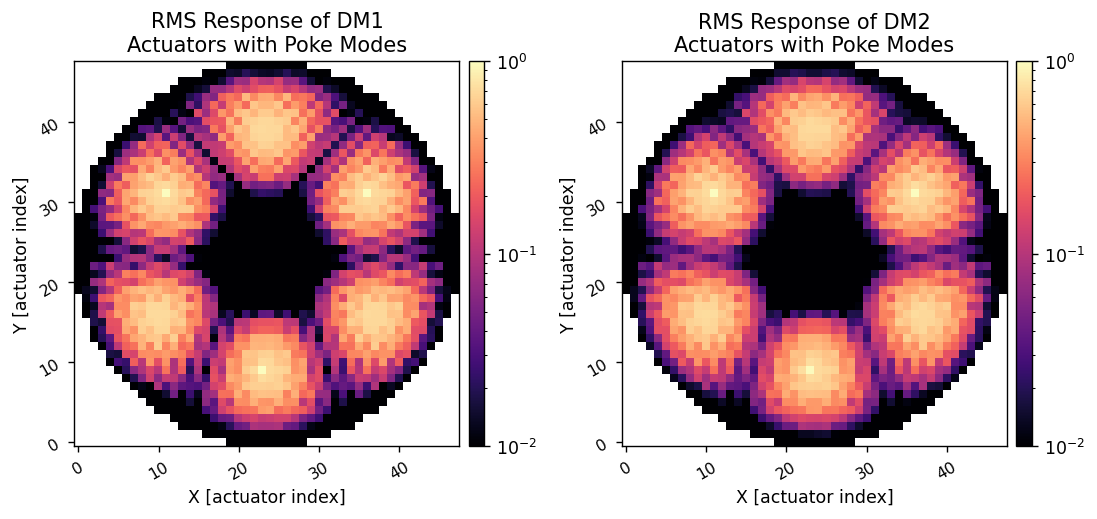

In [18]:
calib_modes = utils.create_all_poke_modes(mode.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
# imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i+mode.Nacts,mode.Nact**2:].reshape(mode.Nact,mode.Nact))


dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
fig,ax = imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Poke Modes', 'RMS Response of DM2\nActuators with Poke Modes',
        lognorm=True, vmax1=1, vmax2=1, vmin1=0.01, vmin2=0.01,
        return_fig=True, display_fig=False,
        wspace=0.3,
        )
ax[0].set_ylabel('Y [actuator index]')
ax[1].set_ylabel('Y [actuator index]')
ax[0].set_xlabel('X [actuator index]')
ax[1].set_xlabel('X [actuator index]')
fig.savefig('figs/poke_mode_responses.pdf', format='pdf', bbox_inches="tight")
display(fig)

In [19]:
date = 20231013
# date = 20231016
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_825_fourier_modes_response_matrix_{date}.fits'))

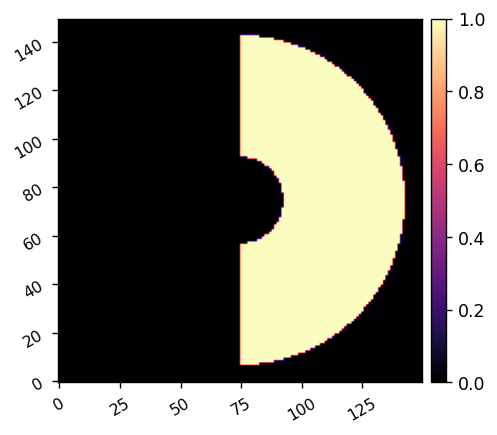

(3512, 4608)
3934552233061.1934


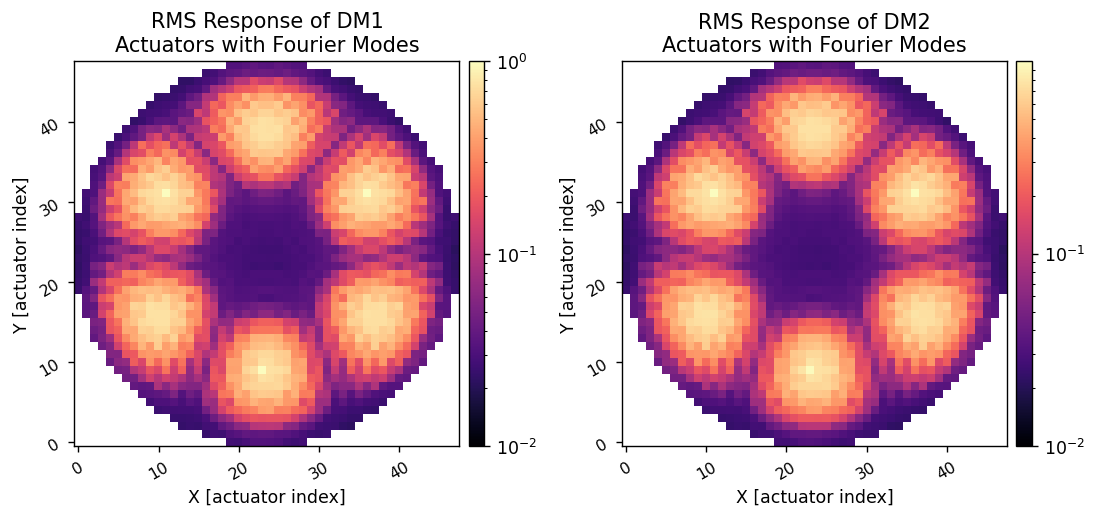

In [20]:
fourier_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=0, plot=True)
calib_modes = utils.create_fourier_modes(mode, fourier_mask, fourier_sampling=0.85, ndms=2)
Nfourier = calib_modes.shape[0]//2
print(calib_modes.shape)
i = 100
# imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), 
#         calib_modes[i+Nfourier,mode.Nact**2:].reshape(mode.Nact,mode.Nact))

response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
fig,ax = imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Fourier Modes', 'RMS Response of DM2\nActuators with Fourier Modes',
        lognorm=True, vmin1=0.01, vmin2=0.01,
        return_fig=True, display_fig=False,
        wspace=0.3,
        )
ax[0].set_ylabel('Y [actuator index]')
ax[1].set_ylabel('Y [actuator index]')
ax[0].set_xlabel('X [actuator index]')
ax[1].set_xlabel('X [actuator index]')
fig.savefig('figs/fourier_mode_responses.pdf', format='pdf', bbox_inches="tight")
display(fig)

In [22]:
date = 20231013
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_825_had_modes_response_matrix_{date}.fits'))

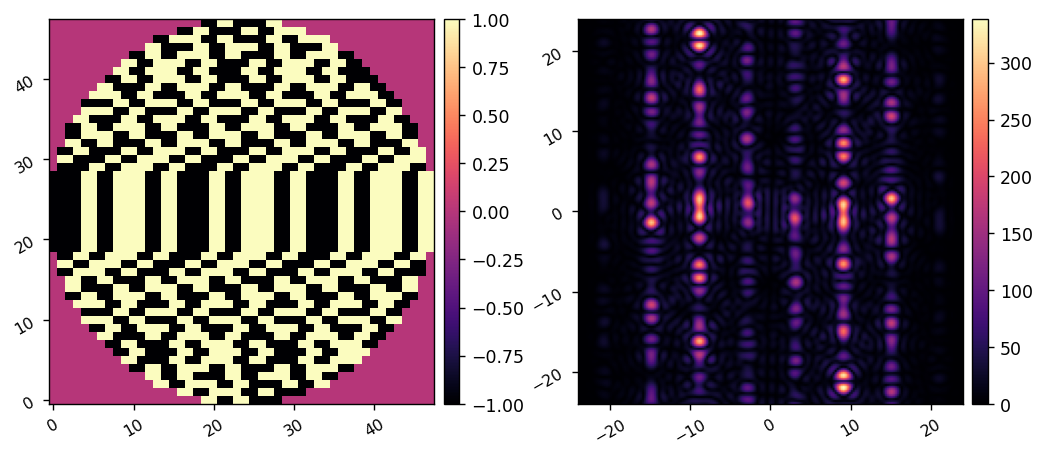

5632018080336.246


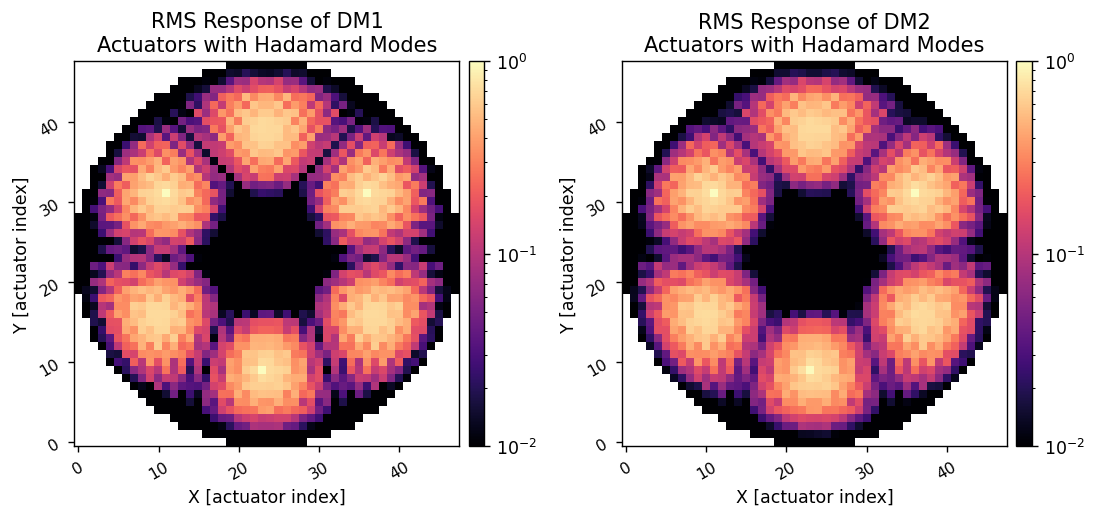

In [23]:
calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)

i = 10
had_mode = calib_modes[i,:mode.Nact**2].reshape(mode.Nact, mode.Nact)
had_response = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(utils.pad_or_crop(had_mode, 48*4))))
imshow2(had_mode, np.abs(had_response), pxscl2=1/4)

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
fig,ax = imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Hadamard Modes', 'RMS Response of DM2\nActuators with Hadamard Modes',
        lognorm=True, vmax1=1, vmax2=1, vmin1=0.01, vmin2=0.01,
        return_fig=True, display_fig=False,
        wspace=0.3,
        )
ax[0].set_ylabel('Y [actuator index]')
ax[1].set_ylabel('Y [actuator index]')
ax[0].set_xlabel('X [actuator index]')
ax[1].set_xlabel('X [actuator index]')
fig.savefig('figs/had_mode_responses.pdf', format='pdf', bbox_inches="tight")
display(fig)

# EFC plots


In [ ]:
date = 20231013

In [24]:
date = 20231013

dm1s_ideal = fits.getdata(response_dir/f'spc_wfov_825_efc_hadamard_dm1_commands_{date}.fits')
dm2s_ideal = fits.getdata(response_dir/f'spc_wfov_825_efc_hadamard_dm2_commands_{date}.fits')
images_ideal = fits.getdata(response_dir/f'spc_wfov_825_efc_hadamard_images_{date}.fits')

images_perturbed = fits.getdata(response_dir/f'spc_wfov_825_efc_perturbed_images_{date}.fits')

1.5766997046190845e-09


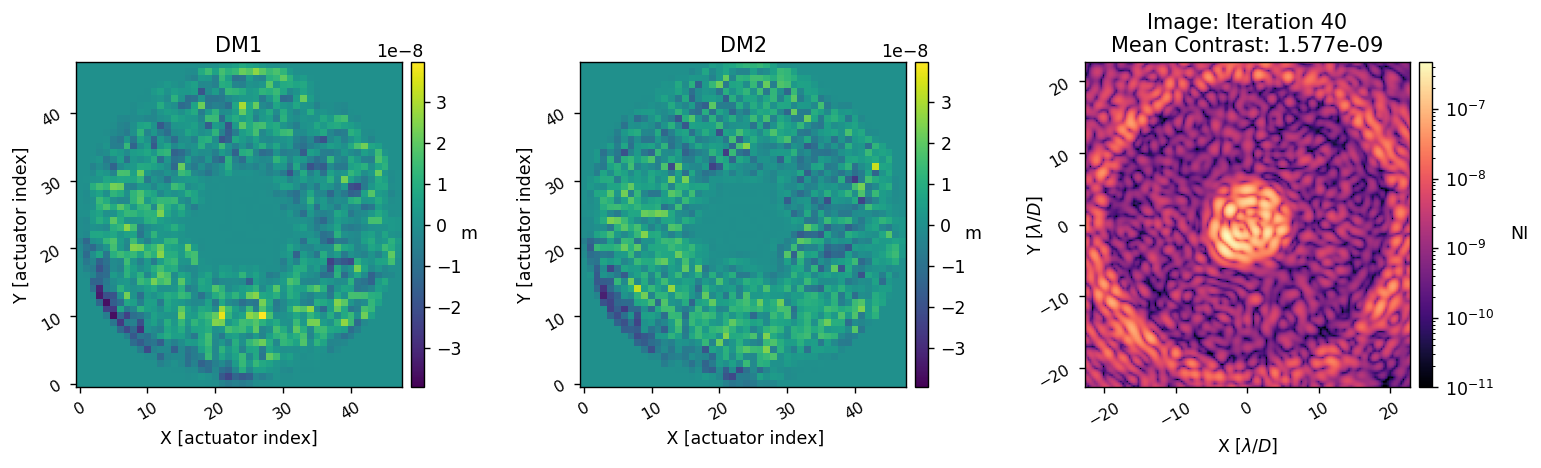

In [25]:
ideal_contrast = np.mean(images_ideal[:,ensure_np_array(control_mask)], axis=1)
i = np.argmin(ideal_contrast)
print(ideal_contrast[i])

dm_max = np.max(np.abs(np.concatenate([dm1s_ideal[i], dm2s_ideal[i]])))
dm1_rms = np.sqrt(np.mean(dm1s_ideal[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s_ideal[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s_ideal[i]) - np.min(dm1s_ideal[i]))*1e9
dm2_p2v = (np.max(dm2s_ideal[i]) - np.min(dm2s_ideal[i]))*1e9
fig, ax = imshow3(dm1s_ideal[i], dm2s_ideal[i], images_ideal[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {ideal_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='X [actuator index]', xlabel2=' X [actuator index]', xlabel3='X [$\lambda/D$]', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        display_fig=False, return_fig=True)
ax[0].set_ylabel('Y [actuator index]', labelpad=5)
ax[1].set_ylabel('Y [actuator index]', labelpad=5)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
fig.savefig('figs/efc_nominal.pdf', format='pdf', bbox_inches="tight")
display(fig)

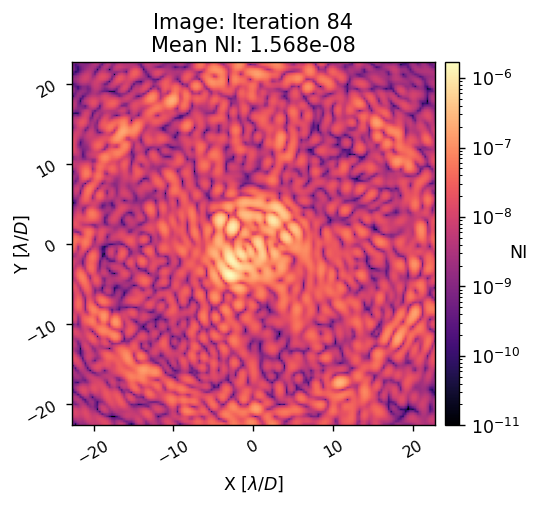

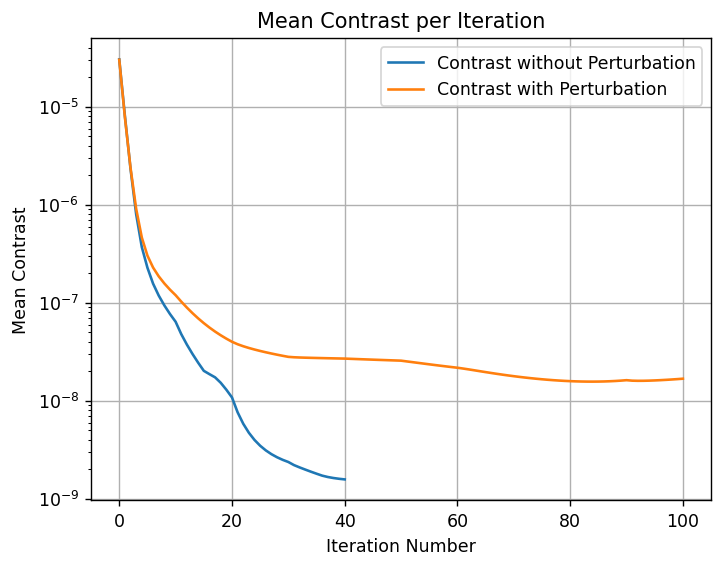

In [26]:
import imshows
reload(imshows)
from imshows import *

mean_nis = np.zeros(len(images_perturbed))
for i in range(len(images_perturbed)):
    mean_nis[i] = np.mean(images_perturbed[i][ensure_np_array(control_mask)])

mean_nis_ideal = []
for i in range(len(images_ideal)):
    mean_nis_ideal.append(np.mean(images_ideal[i][ensure_np_array(control_mask)]))

import matplotlib.pyplot as plt
plt.figure(dpi=125)
plt.semilogy(range(len(images_ideal)), mean_nis_ideal, label='Contrast without Perturbation')
plt.semilogy(range(len(images_perturbed)), mean_nis, label='Contrast with Perturbation')
plt.grid()
plt.ylabel('Mean Contrast')
plt.xlabel('Iteration Number')
plt.title('Mean Contrast per Iteration')
plt.legend()
plt.savefig('figs/perturbed_contrast.pdf', format='pdf', bbox_inches="tight")

imin = np.argmin(mean_nis)
fig,ax = imshow1(images_perturbed[imin], f'Image: Iteration {imin}\nMean NI: {mean_nis[imin]:.3e}', lognorm=True, 
        xlabel='X [$\lambda/D$]', pxscl=mode.psf_pixelscale_lamD, vmin=1e-11, cbar_label='NI',
        return_fig=True, display_fig=False)
ax.set_ylabel('Y [$\lambda/D$]', labelpad=-5)
fig.savefig('figs/perturbed_best_image.pdf', format='pdf', bbox_inches="tight")
display(fig)

In [27]:
from math_module import _scipy

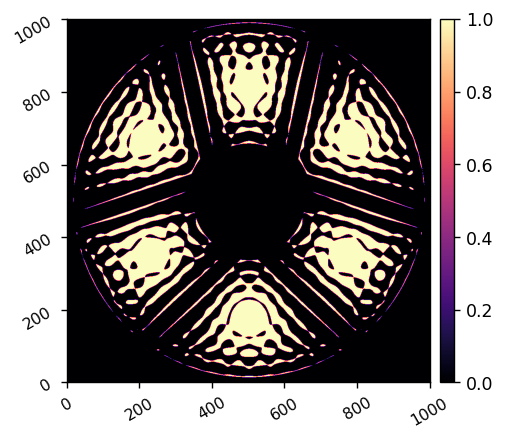

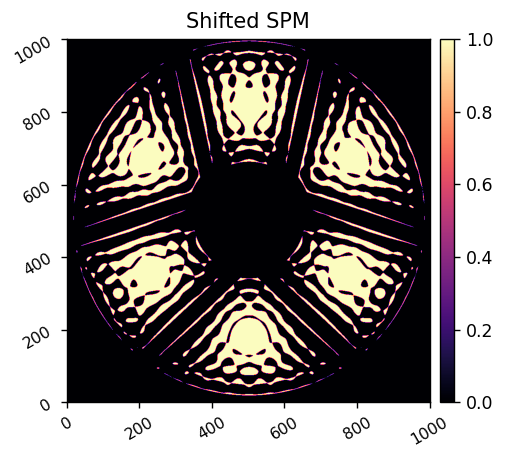

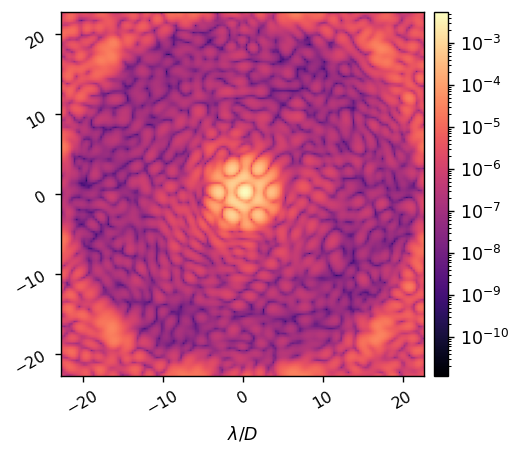

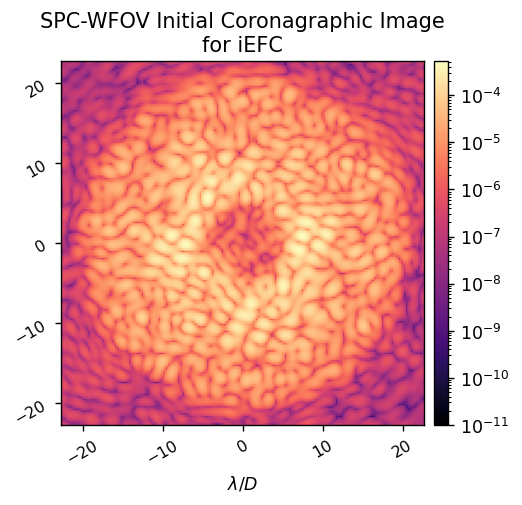

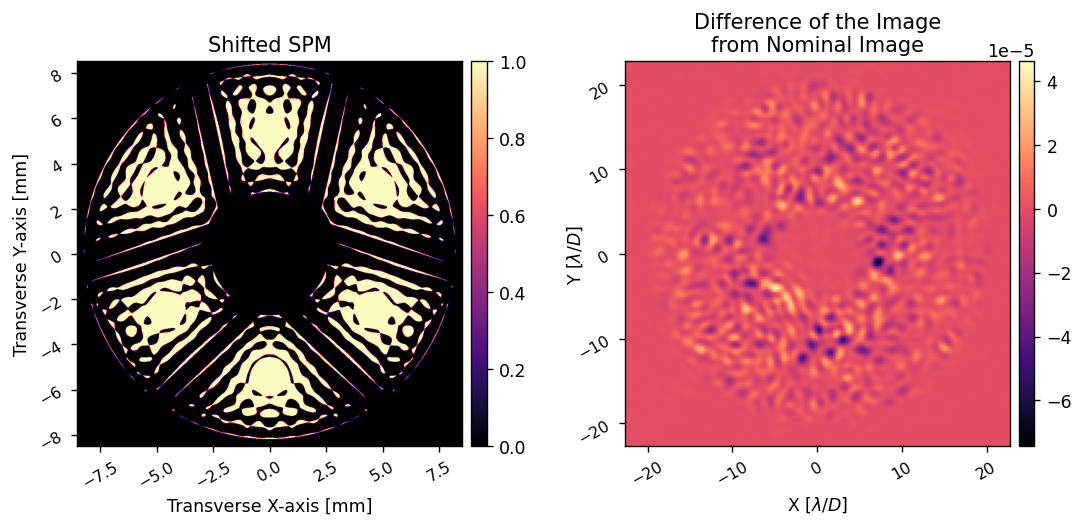

In [28]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True)

# perturb model by slightly shifting the SPM
imshow1(mode.SPM.amplitude)
spm_amp = mode.SPM.amplitude
mode.SPM.amplitude = _scipy.ndimage.shift(spm_amp, (5,0))
imshow1(mode.SPM.amplitude, 'Shifted SPM', )

mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im_shifted = mode.snap()
imshow1(ref_im, 'SPC-WFOV Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

fig,ax = imshow2(mode.SPM.amplitude,  ref_im_shifted - ref_im,
         'Shifted SPM', 'Difference of the Image\nfrom Nominal Image',
         pxscl1=mode.SPM.pixelscale.to(u.mm/u.pix), pxscl2=mode.psf_pixelscale_lamD,
         xlabel1='Transverse X-axis [mm]',  xlabel2='X [$\lambda/D$]',
         wspace=0.3,
         return_fig=True, display_fig=False)

ax[0].set_ylabel('Transverse Y-axis [mm]')
ax[1].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
display(fig)
fig.savefig('figs/shifted_spm.pdf', format='pdf', bbox_inches="tight")
